In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np

from experiment import Experiment
from agent_nn import TwoLayerNNEpsilonGreedy
from agent_nn import TwoLayerNNEpsilonGreedyAnnealing
from agent_nn import TwoLayerNNDropout
from agent_nn import TwoLayerNNEnsembleSampling
from env_nn import TwoLayerNNBandit

In [2]:
def run_one_experiment(experiment_name, param):
    input_dim = 100
    hidden_dim = 50
    num_actions = 100
    time_horizon = 500
    prior_var = 1
    noise_var = 100
    learning_rate=1e-3
    num_gradient_steps=5

    env = TwoLayerNNBandit(input_dim,
                           hidden_dim,
                           num_actions,
                           prior_var,
                           noise_var,)
    actions = env.get_actions()

    if experiment_name == 'ensemble':
        agent = TwoLayerNNEnsembleSampling(input_dim,
                                           hidden_dim,
                                           actions,
                                           time_horizon,
                                           prior_var,
                                           noise_var,
                                           param,
                                           learning_rate,
                                           num_gradient_steps)
    elif experiment_name == 'dropout':
        agent = TwoLayerNNDropout(input_dim,
                                  hidden_dim,
                                  actions,
                                  time_horizon,
                                  prior_var,
                                  noise_var,
                                  param,
                                  learning_rate,
                                  num_gradient_steps)
    elif experiment_name == 'annealing_epsilon_greedy':
        agent = TwoLayerNNEpsilonGreedyAnnealing(input_dim,
                                                 hidden_dim,
                                                 actions,
                                                 time_horizon,
                                                 prior_var,
                                                 noise_var,
                                                 param,
                                                 learning_rate,
                                                 num_gradient_steps)
    elif experiment_name == 'epsilon_greedy':
        agent = TwoLayerNNEpsilonGreedy(input_dim,
                                        hidden_dim,
                                        actions,
                                        time_horizon,
                                        prior_var,
                                        noise_var,
                                        param,
                                        learning_rate,
                                        num_gradient_steps)
    else:
        return

    experiment = Experiment(agent, env, n_steps=time_horizon)
    experiment.run_experiment()

    return experiment

In [3]:
num_simulations = 100

def run_experiments(experiment_name, params):

    if experiment_name == 'ensemble':
        param_name = 'number of models'
    elif experiment_name == 'dropout':
        param_name = 'dropout rate'
    elif experiment_name == 'annealing_epsilon_greedy':
        param_name = 'epsilon=m/(m+t) where m'
    elif experiment_name == 'epsilon_greedy':
        param_name = 'epsilon'
    else:
        print('Invalid experiment_name. Try ensemble, dropout, annealing_epsilon_greedy or epsilon_greedy')
        return

    results = {}
    for param in params:
        exp_batch = []
        for i in range(num_simulations):
            exp = run_one_experiment(experiment_name, param)
            exp_batch.append(exp)
            print(f"Finished experiment {i+1} out of {num_simulations} with {param_name} = {param}", end="\r")
        print(f"Finished all experiments with {param_name}={param}                   ") # to override whole last string
        results[param] = np.mean([exp.results['instant_regret'] for exp in exp_batch], axis=0)
        # results[param] = [np.mean(results[param][:i]) for i in range(1,len(results[param]))]
    return results

In [4]:
%%time
results_epsilon = run_experiments('epsilon_greedy', [0.01, 0.05, 0.1])
results_annealing = run_experiments('annealing_epsilon_greedy', [10, 30, 50])
results_dropout = run_experiments('dropout', [0.3, 0.5, 0.7])
results_ensemble = run_experiments('ensemble', [1, 5, 10])

results_list = [results_epsilon, results_annealing, results_dropout, results_ensemble]

Finished all experiments with epsilon=0.01                   
Finished all experiments with epsilon=0.05                   
Finished all experiments with epsilon=0.1                   
Finished all experiments with epsilon=m/(m+t) where m=10                   
Finished all experiments with epsilon=m/(m+t) where m=30                   
Finished all experiments with epsilon=m/(m+t) where m=50                   
Finished all experiments with dropout rate=0.3                   
Finished all experiments with dropout rate=0.5                   
Finished all experiments with dropout rate=0.7                   
Finished all experiments with number of models=1                   
Finished all experiments with number of models=5                   
Finished all experiments with number of models=10                   
CPU times: total: 9h 30min 32s
Wall time: 1h 35min 31s


In [15]:
%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 12]

def plot_results(results_list):
    fig, axs = plt.subplots(2, 2)

    plt.subplot(2, 2, 1)
    results = results_list[0]
    for param in results:
        axs[0,0].plot(results[param], label = 'epsilon=' + str(param))
    axs[0,0].set_title(f'average per-period regret of epsilon greedy NN over {num_simulations} simulations')

    ################################

    plt.subplot(2, 2, 2)
    results = results_list[1]
    for param in results:
        axs[0,1].plot(results[param], label = f"epsilon={param}/({param}+t)")
    axs[0,1].set_title(f'average per-period regret of annealing epsilon greedy NN over {num_simulations} simulations')

    ################################

    plt.subplot(2, 2, 3)
    results = results_list[2]
    for param in results:
        axs[1,0].plot(results[param], label = 'dropout=' + str(param))
    axs[1,0].set_title(f'average per-period regret of Dropout NN over {num_simulations} simulations')

    ###############################

    plt.subplot(2, 2, 4)
    results = results_list[3]
    for param in results:
        axs[1,1].plot(results[param], label = 'M=' + str(param))
    axs[1,1].set_title(f'average per-period regret of Ensemble Sampling over {num_simulations} simulations')

    for i in [(0,0), (0,1), (1,0), (1,1)]:
        axs[i].set_xlabel('time period')
        axs[i].set_ylabel(None)
        axs[i].legend()
        axs[i].set_xlim(0, 500)
        axs[i].set_ylim(0, 70)

    plt.show()

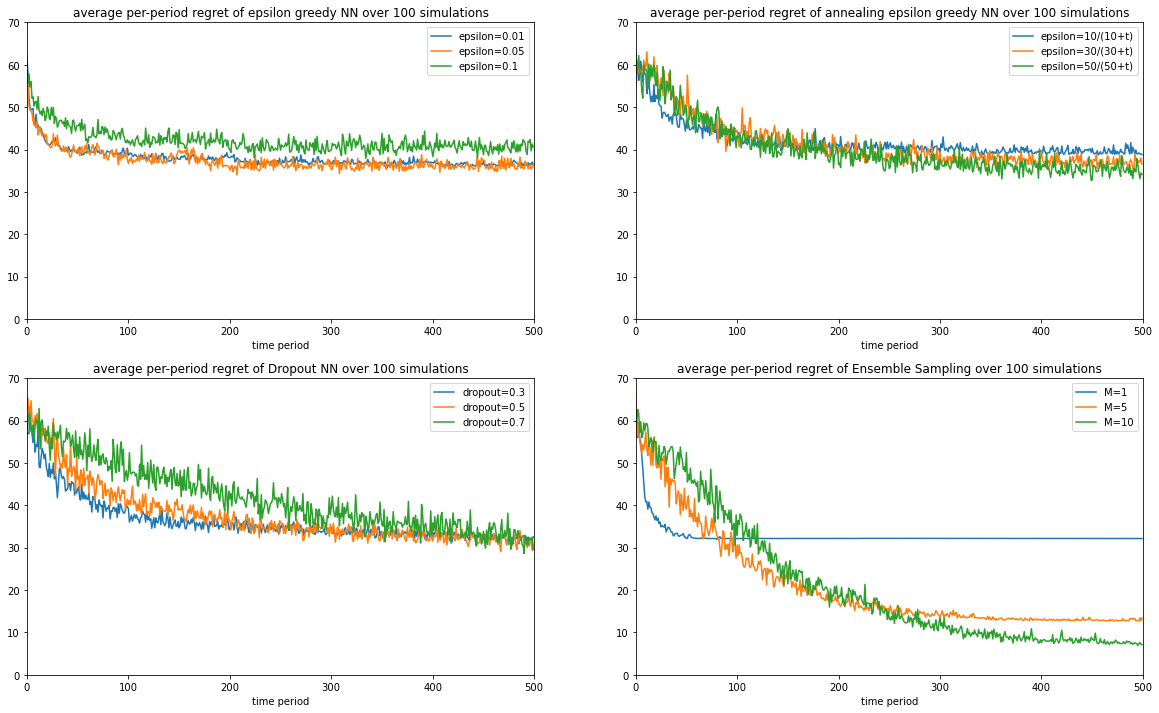

In [16]:
plot_results(results_list)